Notebook inspried by https://www.kaggle.com/code/ambrosm/pss4e4-eda-which-makes-sense/notebook

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost

from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, SplineTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

train = pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/home/tomruge/Schreibtisch/Data/Kaggle/playground-series-s4e4/test.csv', index_col='id')

train['Sex'] = train.Sex.astype('category')
test['Sex'] = test.Sex.astype(train.Sex.dtype)

if not train.isna().any().any():
    print('There are no missing values in train.')
if not test.isna().any().any():
    print('There are no missing values in test.')
    
print(f"Train shape: {train.shape}   test shape: {test.shape}")
    
numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
numeric_vars = numeric_features + ['Rings']

# Configuration
COMPUTE_TEST_PRED = True
USE_ORIGINAL_DATA = True

# Containers for results
oof, test_pred = {}, {}

There are no missing values in train.
There are no missing values in test.
Train shape: (90615, 9)   test shape: (60411, 8)


In [12]:
if USE_ORIGINAL_DATA:
    !pip install ucimlrepo

    from ucimlrepo import fetch_ucirepo 

    # fetch dataset 
    abalone = fetch_ucirepo(id=1) 

    # data (as pandas dataframes)
    original_dataset = pd.concat([abalone.data.features, abalone.data.targets], axis = 1).rename({
        'Whole_weight' : 'Whole weight',
        'Shucked_weight' : 'Whole weight.1',
        'Viscera_weight' : 'Whole weight.2',
        'Shell_weight' : 'Shell weight'
    }, axis = 1)
    original_dataset['Sex'] = original_dataset.Sex.astype(train.Sex.dtype)
    print("Original dataset shape:", original_dataset.shape)

Original dataset shape: (4177, 9)


In [13]:
log_features = []
for col in numeric_features:
    train[f'log_{col}'] = np.log1p(train[col])
    test[f'log_{col}'] = np.log1p(test[col])
    if USE_ORIGINAL_DATA:
        original_dataset[f'log_{col}'] = np.log1p(original_dataset[col])
    log_features.append(f'log_{col}')

In [14]:


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

def cross_validate(model, label, features=test.columns, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.
    
    If n_repeats > 1, the model is trained several times with different seeds.
    
    All predictions are clipped to the interval [1, 29].
    """
    scores = []
    oof_preds = np.full_like(train.Rings, np.nan, dtype=float)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.Rings)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = train.iloc[idx_tr].Rings
        y_va = train.iloc[idx_va].Rings
        
        if USE_ORIGINAL_DATA:
            X_tr = pd.concat([X_tr, original_dataset[features]], axis=0)
            y_tr = pd.concat([y_tr, original_dataset.Rings], axis=0)
            
        y_pred = np.zeros_like(y_va, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        
#         residuals = np.log1p(y_va) - np.log1p(y_pred)
#         plt.figure(figsize=(6, 2))
#         plt.scatter(y_pred, residuals, s=1)
#         plt.axhline(0, color='k')
#         plt.show()
        
        score = mean_squared_log_error(y_va, y_pred, squared=False)
        print(f"# Fold {fold}: RMSLE={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
    print(f"{Fore.GREEN}# Overall: {np.array(scores).mean():.5f} {label}{Style.RESET_ALL}")
    oof[label] = oof_preds
    
    if COMPUTE_TEST_PRED:
        # Retrain n_repeats times with the whole dataset and average
        y_pred = np.zeros(len(test), dtype=float)
        X_tr = train[features]
        y_tr = train.Rings
        if USE_ORIGINAL_DATA:
            X_tr = pd.concat([X_tr, original_dataset[features]], axis=0)
            y_tr = pd.concat([y_tr, original_dataset.Rings], axis=0)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        test_pred[label] = y_pred
    

Models

In [15]:
# PolynomialFeatures + Ridge
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), ['Sex'])],
                                        remainder='passthrough'),
                      StandardScaler(),
                      PolynomialFeatures(degree=3),
                      TransformedTargetRegressor(Ridge(100),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'Poly-Ridge', numeric_features + log_features + ['Sex'])
# Overall: 0.15293 Poly-Ridge



# Fold 0: RMSLE=0.15127
# Fold 1: RMSLE=0.15290
# Fold 2: RMSLE=0.15337
# Fold 3: RMSLE=0.15325
# Fold 4: RMSLE=0.15298
# Overall: 0.15275 Poly-Ridge


In [16]:


# Catboost
# Hyperparameters were tuned with Optuna
cb_params = {'grow_policy': 'SymmetricTree', 'n_estimators': 1000, 'learning_rate': 0.128912681527133, 'l2_leaf_reg': 1.836927907521674, 'max_depth': 6, 'colsample_bylevel': 0.6775373040510968, 'random_strength': 0, 'boost_from_average': True, 'loss_function': 'RMSE', 'cat_features': ['Sex'], 'verbose': False} # 0.14847
model = TransformedTargetRegressor(catboost.CatBoostRegressor(**cb_params),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)
cross_validate(model, 'Catboost', log_features + ['Sex'], n_repeats=5)
# Overall: 0.14851 Catboost



# Fold 0: RMSLE=0.14638
# Fold 1: RMSLE=0.14834
# Fold 2: RMSLE=0.14914
# Fold 3: RMSLE=0.14894
# Fold 4: RMSLE=0.14851
# Overall: 0.14826 Catboost


In [17]:


# LightGBM with sqrt transformation
# Hyperparameters were tuned with Optuna
lgbm_params = {'n_estimators': 1000, 'learning_rate': 0.038622511348472645, 'colsample_bytree': 0.5757189042456357, 'reg_lambda': 0.09664116733307193, 'min_child_samples': 87, 'num_leaves': 43, 'verbose': -1} # 0.14804
model = TransformedTargetRegressor(lightgbm.LGBMRegressor(**lgbm_params),
                                                 func=np.sqrt,
                                                 inverse_func=np.square)
cross_validate(model, 'LightGBM-sqrt', numeric_features + ['Sex'], n_repeats=5)



# Fold 0: RMSLE=0.14600
# Fold 1: RMSLE=0.14814
# Fold 2: RMSLE=0.14880
# Fold 3: RMSLE=0.14848
# Fold 4: RMSLE=0.14837
# Overall: 0.14796 LightGBM-sqrt


In [18]:


# LightGBM
# Hyperparameters were tuned with Optuna
lgbm_params = {'n_estimators': 1000, 'learning_rate': 0.038622511348472645, 'colsample_bytree': 0.5757189042456357, 'reg_lambda': 0.09664116733307193, 'min_child_samples': 87, 'num_leaves': 43, 'verbose': -1} # 0.14804
model = TransformedTargetRegressor(lightgbm.LGBMRegressor(**lgbm_params),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)
cross_validate(model, 'LightGBM', numeric_features + ['Sex'], n_repeats=5)
# Overall: 0.14804 LightGBM



# Fold 0: RMSLE=0.14583
# Fold 1: RMSLE=0.14799
# Fold 2: RMSLE=0.14866
# Fold 3: RMSLE=0.14843
# Fold 4: RMSLE=0.14819
# Overall: 0.14782 LightGBM


In [19]:


# XGBoost with RMSLE objective
# Hyperparameters were tuned with Optuna
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 500, 'learning_rate': 0.0896765799823656, 'max_depth': 8, 'reg_lambda': 1.003764844090402, 'min_child_weight': 0.20627702562667777, 'colsample_bytree': 0.5142803343048419, 'objective': 'reg:squaredlogerror', 'tree_method': 'hist', 'gamma': 0, 'enable_categorical': True} # 0.14875
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost-RMSLE', numeric_features + ['Sex'], n_repeats=5)



# Fold 0: RMSLE=0.14699
# Fold 1: RMSLE=0.14876
# Fold 2: RMSLE=0.14945
# Fold 3: RMSLE=0.14936
# Fold 4: RMSLE=0.14881
# Overall: 0.14868 XGBoost-RMSLE


Ensemble weights
Poly-Ridge       0.007237
Catboost         0.280214
LightGBM-sqrt    0.317594
LightGBM         0.305431
XGBoost-RMSLE    0.092825
dtype: float64
Total weight: 1.0033004824753415
Intercept: -0.009221257172165043
Score: 0.14765


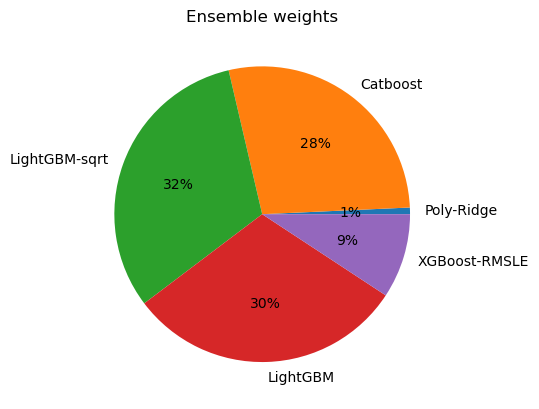

In [20]:
members = [name for name in oof.keys() if 'Stack' not in name]

X = np.log1p(np.column_stack([oof[name] for name in members]))
model = TransformedTargetRegressor(Ridge(positive=True, tol=1e-6),
                                   func=np.log1p,
                                   inverse_func=np.expm1)
model.fit(X, train.Rings)
print('Ensemble weights')
weights = pd.Series(model.regressor_.coef_, index=members)
print(weights)
print('Total weight:', weights.sum())
print('Intercept:', model.regressor_.intercept_)
oof['Stack'] = model.predict(X) # not really out-of-fold...
print(f"Score: {mean_squared_log_error(train.Rings, oof['Stack'], squared=False):.5f}")

# Pie chart
weights = weights[weights >= 0.005] # hide small weights in pie chart
plt.pie(weights, labels=weights.index, autopct="%.0f%%")
plt.title('Ensemble weights')
plt.show()

# Test predictions
if COMPUTE_TEST_PRED:
    X = np.log1p(np.column_stack([test_pred[name] for name in members]))
    test_pred['Stack'] = model.predict(X)


In [21]:
if COMPUTE_TEST_PRED:
    sub = pd.Series(test_pred['Stack'], index=test.index, name='Rings')
    sub.to_csv('submission.csv')
    !head submission.csv


id,Rings
90615,9.660600868120667
90616,9.73774241884161
90617,9.842901016475754
90618,10.575212607339846
90619,7.622361277264611
90620,9.30623534948487
90621,11.046993659017348
90622,6.122991911745492
90623,7.911552166289258


-> Great Notebook I need to work more on it and try to imporve this one